# Project: Predicting no-shows in medical appointments

## Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score, classification_report, mutual_info_score, accuracy_score
from sklearn.tree import export_text
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import lightgbm as lgb

import pickle

sns.set_style("whitegrid")
sns.set_palette('muted')

In [2]:
for package in [pd, np, mpl, sns, sklearn, xgb, pickle, lgb]:
    if package == pickle: print(f'{package.__name__:<12}: {package.format_version}')
    else: print(f'{package.__name__:<12}: {package.__version__}')

pandas      : 2.1.1
numpy       : 1.26.0
matplotlib  : 3.8.0
seaborn     : 0.12.2
sklearn     : 1.3.0
xgboost     : 1.7.3
pickle      : 4.0
lightgbm    : 3.3.5


# Data Loading

The Kaggle dataset for this project can be downloaded from: https://www.kaggle.com/datasets/joniarroba/noshowappointments/data

Details of the dataset, including description of columns and associated datatypes, can be found [here](../data/README.md).

In [3]:
data_loc = '../data/KaggleV2-May-2016.csv'
#data_loc = '/kaggle/input/noshowappointments/KaggleV2-May-2016.csv'

In [4]:
df = pd.read_csv(data_loc, 
                 parse_dates=['ScheduledDay', 'AppointmentDay'],
                 dtype={
                            'Scholarship':'bool',
                            'Hipertension':'bool',
                            'Diabetes':'bool',
                            'Alcoholism':'bool',
                            'SMS_received':'bool'
                     }
              )
df.info()
df.tail().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   PatientId       110527 non-null  float64            
 1   AppointmentID   110527 non-null  int64              
 2   Gender          110527 non-null  object             
 3   ScheduledDay    110527 non-null  datetime64[ns, UTC]
 4   AppointmentDay  110527 non-null  datetime64[ns, UTC]
 5   Age             110527 non-null  int64              
 6   Neighbourhood   110527 non-null  object             
 7   Scholarship     110527 non-null  bool               
 8   Hipertension    110527 non-null  bool               
 9   Diabetes        110527 non-null  bool               
 10  Alcoholism      110527 non-null  bool               
 11  Handcap         110527 non-null  int64              
 12  SMS_received    110527 non-null  bool               
 13  No-show       

,110522,110523,110524,110525,110526
PatientId,2572134369293.0,3596266328735.0,15576631729893.0,92134931435557.0,377511518121127.0
AppointmentID,5651768,5650093,5630692,5630323,5629448
Gender,F,F,F,F,F
ScheduledDay,2016-05-03 09:15:35+00:00,2016-05-03 07:27:33+00:00,2016-04-27 16:03:52+00:00,2016-04-27 15:09:23+00:00,2016-04-27 13:30:56+00:00
AppointmentDay,2016-06-07 00:00:00+00:00,2016-06-07 00:00:00+00:00,2016-06-07 00:00:00+00:00,2016-06-07 00:00:00+00:00,2016-06-07 00:00:00+00:00
Age,56,51,21,38,54
Neighbourhood,MARIA ORTIZ,MARIA ORTIZ,MARIA ORTIZ,MARIA ORTIZ,MARIA ORTIZ
Scholarship,False,False,False,False,False
Hipertension,False,False,False,False,False
Diabetes,False,False,False,False,False


# Data cleaning and preparation

* Correct typos
* Make the column names lower-case and uniform
* Make the string values of categorical columns lower-case and uniform
* Impute/Handle missing values [there are no missing values in this dataset]
* Make the target variable boolean

In [5]:
df.rename(columns={'Hipertension':'Hypertension'}, inplace=True)

In [6]:
# Make the column names lower-case and uniform
df.columns = df.columns.str.lower().str.replace('-', '_')
#df.columns

In [7]:
df.dtypes[df.dtypes == 'object'].index.tolist()

['gender', 'neighbourhood', 'no_show']

In [8]:
# Make the string values of categorical columns lower-case and uniform

categorical_columns = df.dtypes[df.dtypes == 'object'].index.tolist()

for col in categorical_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [9]:
for col in categorical_columns:
    print(col)
    print(df[col].unique()[:5])
    print(df[col].nunique())
    print()

gender
['f' 'm']
2

neighbourhood
['jardim_da_penha' 'mata_da_praia' 'pontal_de_camburi' 'república'
 'goiabeiras']
81

no_show
['no' 'yes']
2



In [10]:
# Make the target variable boolean
df.no_show = (df.no_show == 'yes').astype(int)

In [11]:
## Impute/Handle missing values: There are no missing values in this dataset
df.isnull().sum().sum()

0

In [12]:
# dataframe after data cleaning/preparation

df.tail().T

,110522,110523,110524,110525,110526
patientid,2572134369293.0,3596266328735.0,15576631729893.0,92134931435557.0,377511518121127.0
appointmentid,5651768,5650093,5630692,5630323,5629448
gender,f,f,f,f,f
scheduledday,2016-05-03 09:15:35+00:00,2016-05-03 07:27:33+00:00,2016-04-27 16:03:52+00:00,2016-04-27 15:09:23+00:00,2016-04-27 13:30:56+00:00
appointmentday,2016-06-07 00:00:00+00:00,2016-06-07 00:00:00+00:00,2016-06-07 00:00:00+00:00,2016-06-07 00:00:00+00:00,2016-06-07 00:00:00+00:00
age,56,51,21,38,54
neighbourhood,maria_ortiz,maria_ortiz,maria_ortiz,maria_ortiz,maria_ortiz
scholarship,False,False,False,False,False
hypertension,False,False,False,False,False
diabetes,False,False,False,False,False


# EDA

* target variable
* input features:
    * PatientId, AppointmentId
    * Datetime variables: ScheduledDay, AppointmentDay
    * Categorical/discontinuous variables
    * Continuous variables

## Target Variable: No-Show

0.20193255946510807


Text(0.5, 1.0, 'Normalised Value Counts')

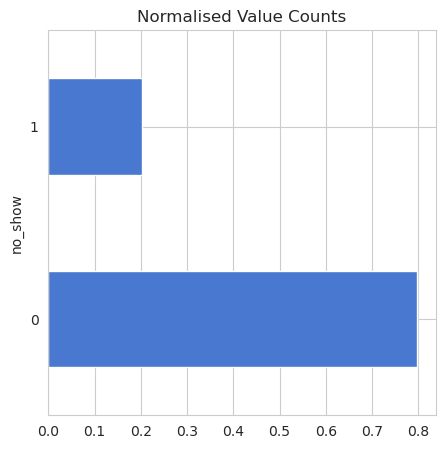

In [13]:
print(df.no_show.mean())

fig, ax = plt.subplots(figsize=(5,5))
df.no_show.value_counts(normalize=True).plot.barh(ax=ax)
ax.set_title('Normalised Value Counts')

## Input-Features

### PatientId, AppointmentId
* The dataset consists of 1.77 appointments per unique patientId
* Drop appointmentId column because it does not add information

In [14]:
print(df.patientid.nunique())
print(df.appointmentid.nunique())

62299
110527


In [15]:
df.drop(columns='appointmentid', inplace=True)

### Datetime columns: ['scheduledday', 'appointmentday']

* What are the time periods involved?
* How do the time series look like?

In [16]:
for col in ['scheduledday', 'appointmentday']:
    print(f'{col}: {df[col].min().date()} -- {df[col].max().date()} ')

scheduledday: 2015-11-10 -- 2016-06-08 
appointmentday: 2016-04-29 -- 2016-06-08 


Text(0.5, 0.98, 'Counts of No-shows')

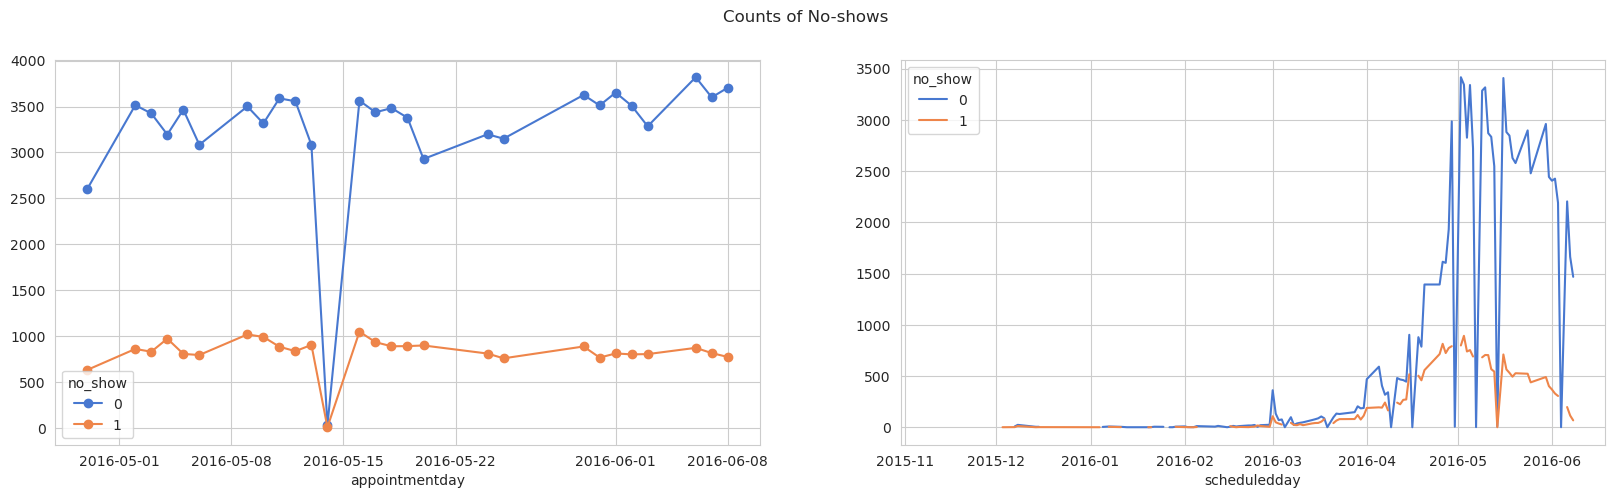

In [17]:
fig, axs = plt.subplots(ncols=2, figsize=(20,5))

df.groupby([df.appointmentday.dt.date, df.no_show]).count()['patientid'].unstack().plot(ax=axs[0], marker='o')
df.groupby([df.scheduledday.dt.date, df.no_show]).count()['patientid'].unstack().plot(ax=axs[1])

fig.suptitle('Counts of No-shows')

In [18]:
df.columns

Index(['patientid', 'gender', 'scheduledday', 'appointmentday', 'age',
       'neighbourhood', 'scholarship', 'hypertension', 'diabetes',
       'alcoholism', 'handcap', 'sms_received', 'no_show'],
      dtype='object')

### Discontinuous variables

* 'gender', 
* 'neighbourhood'
* 'scholarship'
* 'hipertension',
* 'diabetes'
* 'alcoholism'
* 'handcap'
* 'sms_received'

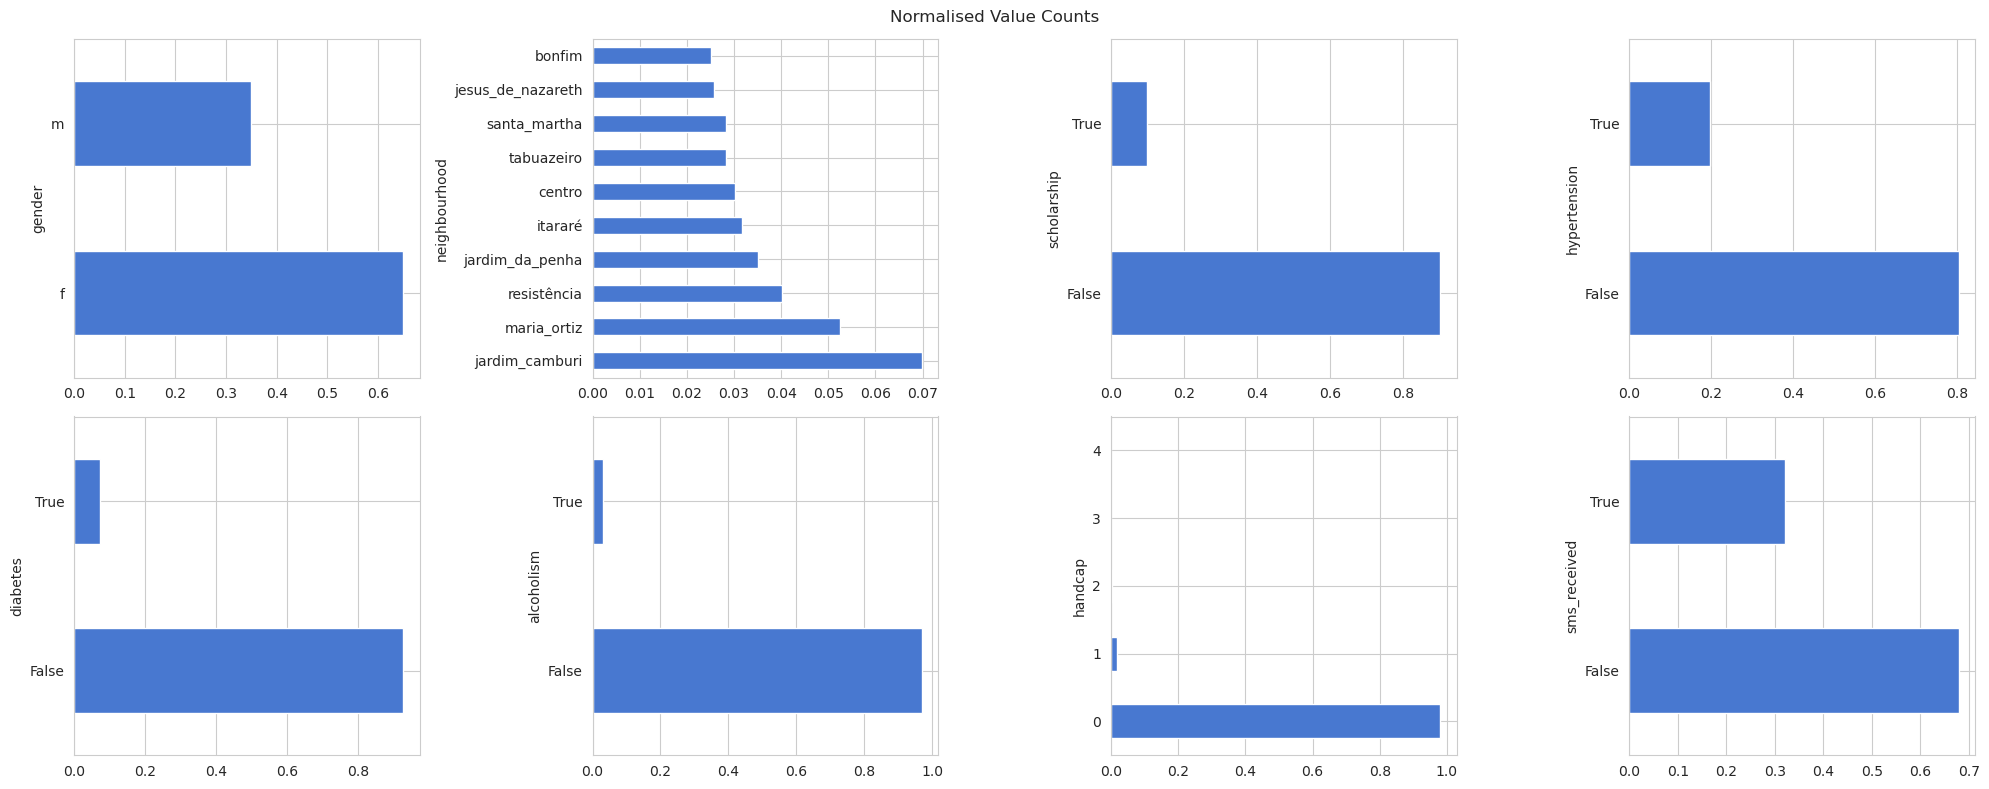

In [19]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20,8))


for idx, col in enumerate(['gender','neighbourhood', 'scholarship', 'hypertension','diabetes', 'alcoholism', 'handcap', 'sms_received']):
    df[col].value_counts(normalize=True)[:10].plot.barh(ax=axs[int(idx/4), idx%4])

fig.suptitle('Normalised Value Counts')
plt.tight_layout()

### Continuous Variables: Age

Text(0.5, 1.0, 'Age histogram')

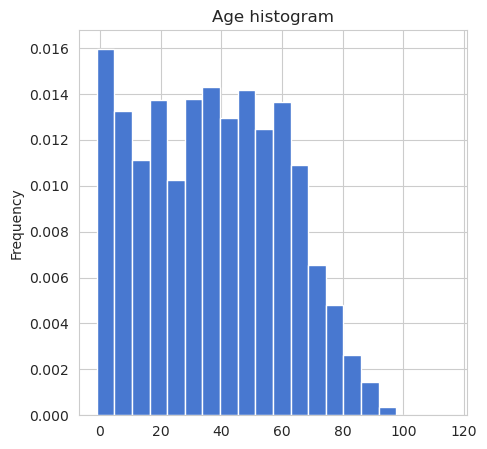

In [20]:
fig, ax = plt.subplots(figsize=(5,5))
df.age.plot.hist(bins=20, density=True)
ax.set_title('Age histogram')

# Feature Engineering

* Construct datetime-related features out of 'scheduledday' and 'appointmentday' which can be treated as numerical or categorical data, instead of datetime data
* Drop columns 'scheduledday' and 'appointmentday'
* Drop any column which has only 1 unique value

In [21]:
# Credit: https://github.com/fastai/fastai/blob/master/fastai/tabular/core.py#L26

attr = ['Year', 'Month', 'Week', 'Day', 
        'Dayofweek', 'Dayofyear', 
        'Is_month_end', 'Is_month_start', 
        'Is_quarter_end', 'Is_quarter_start',  
        'Hour', 'Minute', 'Second']

for field_name in ['scheduledday', 'appointmentday']:

    field = df[field_name]
    prefix = field_name
    
    week = field.dt.isocalendar().week.astype(field.dt.day.dtype) if hasattr(field.dt, 'isocalendar') else field.dt.week
    for n in attr: df[prefix + n] = getattr(field.dt, n.lower()) if n != 'Week' else week   

    df.drop(field_name, axis=1, inplace=True)

    # drop columns which only have one unique value
    n = df[[col for col in df.columns if col.startswith('appointmentday')]].nunique() == 1
    #print(n[n == True].index)
    df.drop(n[n == True].index, axis=1, inplace=True)


df.tail().T


,110522,110523,110524,110525,110526
patientid,2572134369293.0,3596266328735.0,15576631729893.0,92134931435557.0,377511518121127.0
gender,f,f,f,f,f
age,56,51,21,38,54
neighbourhood,maria_ortiz,maria_ortiz,maria_ortiz,maria_ortiz,maria_ortiz
scholarship,False,False,False,False,False
hypertension,False,False,False,False,False
diabetes,False,False,False,False,False
alcoholism,False,False,False,False,False
handcap,0,0,0,0,0
sms_received,True,True,True,True,True


# Categorical/Numerical Features

* Divide the dataset into numerical and categorical features depending on how many unique values the variable can have (< or > 10)
* Remove target variable from list of categorical columns
* Make an exception for 'neighbourhood' which has 81 unique values but clearly is a categorical variable

In [22]:
categorical = [col for col in df.columns if df[col].nunique() <= 10] + ['neighbourhood']
categorical.remove('no_show')

numerical = [col for col in df.columns if df[col].nunique() > 10]
numerical.remove('neighbourhood')

print(f'Categorical: {categorical}')
print(f'Numerical: {numerical}')

assert(set(numerical + categorical + ['no_show']) == set(df.columns))

Categorical: ['gender', 'scholarship', 'hypertension', 'diabetes', 'alcoholism', 'handcap', 'sms_received', 'scheduleddayYear', 'scheduleddayMonth', 'scheduleddayDayofweek', 'scheduleddayIs_month_end', 'scheduleddayIs_month_start', 'scheduleddayIs_quarter_end', 'scheduleddayIs_quarter_start', 'appointmentdayMonth', 'appointmentdayWeek', 'appointmentdayDayofweek', 'appointmentdayIs_month_end', 'appointmentdayIs_month_start', 'neighbourhood']
Numerical: ['patientid', 'age', 'scheduleddayWeek', 'scheduleddayDay', 'scheduleddayDayofyear', 'scheduleddayHour', 'scheduleddayMinute', 'scheduleddaySecond', 'appointmentdayDay', 'appointmentdayDayofyear']


# Feature importance

## Feature Importance: Mutual information

Mutual information: concept from information theory, it tells us how much we can learn about one variable if we know the value of another
* https://en.wikipedia.org/wiki/Mutual_information

In [23]:
df[categorical].nunique()

gender                           2
scholarship                      2
hypertension                     2
diabetes                         2
alcoholism                       2
handcap                          5
sms_received                     2
scheduleddayYear                 2
scheduleddayMonth                8
scheduleddayDayofweek            6
scheduleddayIs_month_end         2
scheduleddayIs_month_start       2
scheduleddayIs_quarter_end       2
scheduleddayIs_quarter_start     2
appointmentdayMonth              3
appointmentdayWeek               7
appointmentdayDayofweek          6
appointmentdayIs_month_end       2
appointmentdayIs_month_start     2
neighbourhood                   81
dtype: int64

scheduleddayMonth               1.510020e-02
sms_received                    7.701460e-03
neighbourhood                   2.192090e-03
hypertension                    6.559947e-04
appointmentdayWeek              5.219251e-04
scholarship                     4.093512e-04
appointmentdayMonth             3.117944e-04
scheduleddayIs_quarter_end      2.211698e-04
scheduleddayIs_month_end        1.423530e-04
appointmentdayDayofweek         1.239311e-04
scheduleddayIs_quarter_start    1.226543e-04
diabetes                        1.182674e-04
scheduleddayIs_month_start      1.165667e-04
appointmentdayIs_month_end      6.614139e-05
appointmentdayIs_month_start    5.371608e-05
scheduleddayDayofweek           4.737024e-05
handcap                         3.251833e-05
scheduleddayYear                1.710510e-05
gender                          8.492551e-06
alcoholism                      1.922678e-08
dtype: float64

Text(0.5, 1.0, 'Mutual Information: Top 10 categorical features')

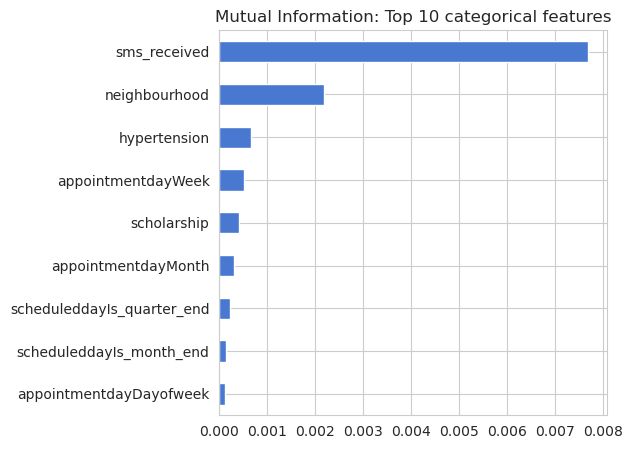

In [24]:
def mutual_info_no_show_score(series):
    return mutual_info_score(series, df.no_show)

mi = df[categorical].apply(mutual_info_no_show_score)

display(mi.sort_values(ascending=False))

fig, ax = plt.subplots(figsize=(5,5))
mi.sort_values(ascending=False)[1:10][::-1].plot.barh(ax=ax)
ax.set_title('Mutual Information: Top 10 categorical features')

## Feature importance: Correlation

What about Numerical columns?
Correlation coefficient - https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

scheduleddayDayofyear      0.157280
scheduleddayWeek           0.156386
scheduleddayHour           0.060697
age                        0.060319
scheduleddayDay            0.046557
appointmentdayDayofyear    0.022408
scheduleddayMinute         0.015037
appointmentdayDay          0.003763
scheduleddaySecond         0.001837
patientid                  0.001461
dtype: float64

Text(0.5, 1.0, 'Correlation: Top 10 numerical features')

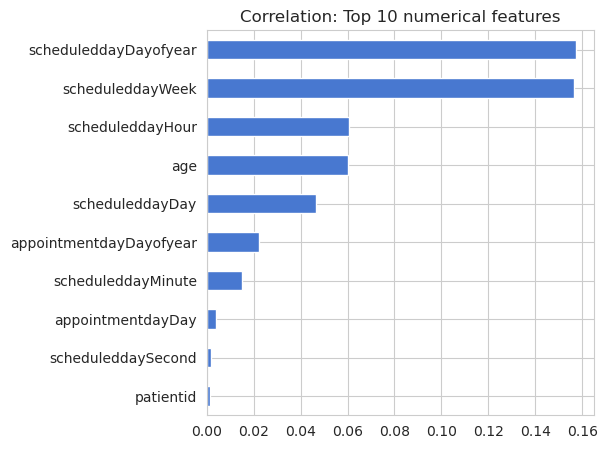

In [25]:
corr = df[numerical].corrwith(df.no_show).abs().sort_values(ascending=False)
display(corr)

fig, ax = plt.subplots(figsize=(5,5))
corr[::-1].plot.barh(ax=ax)
ax.set_title('Correlation: Top 10 numerical features')

# Setting up the validation framework

* Perform the train/validation/test split with Scikit-Learn

In [26]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.no_show.values
y_val = df_val.no_show.values
y_test = df_test.no_show.values

del df_train['no_show']
del df_val['no_show']
del df_test['no_show']

# Data Preparation-II: Feature Scaling + OHE

### Training set: Feature Scaling

First, we prepare the numerical variables. We'll use the scaler for that and write the results to `X_train_num`. The scaler scales the numerical features.

In [27]:
X_train_num = df_train[numerical]

scaler = StandardScaler()
#scaler = MinMaxScaler()

X_train_num = scaler.fit_transform(X_train_num)

Now let's process categorical features using OneHotEncoding. We'll write the results to `X_train_cat`.

In [28]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_train_cat = ohe.fit_transform(df_train[categorical])
ohe.get_feature_names_out()

/home/ubuntu/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array(['gender_f', 'gender_m', 'scholarship_False', 'scholarship_True',
       'hypertension_False', 'hypertension_True', 'diabetes_False',
       'diabetes_True', 'alcoholism_False', 'alcoholism_True',
       'handcap_0', 'handcap_1', 'handcap_2', 'handcap_3', 'handcap_4',
       'sms_received_False', 'sms_received_True', 'scheduleddayYear_2015',
       'scheduleddayYear_2016', 'scheduleddayMonth_1',
       'scheduleddayMonth_2', 'scheduleddayMonth_3',
       'scheduleddayMonth_4', 'scheduleddayMonth_5',
       'scheduleddayMonth_6', 'scheduleddayMonth_11',
       'scheduleddayMonth_12', 'scheduleddayDayofweek_0',
       'scheduleddayDayofweek_1', 'scheduleddayDayofweek_2',
       'scheduleddayDayofweek_3', 'scheduleddayDayofweek_4',
       'scheduleddayDayofweek_5', 'scheduleddayIs_month_end_False',
       'scheduleddayIs_month_end_True',
       'scheduleddayIs_month_start_False',
       'scheduleddayIs_month_start_True',
       'scheduleddayIs_quarter_end_False',
       'scheduledda

In [29]:
X_train = np.column_stack([X_train_num, X_train_cat])

In [30]:
features = [feature for feature in np.append(scaler.get_feature_names_out(),ohe.get_feature_names_out())]

### Validation set: Transformation

In [31]:
X_val_num = df_val[numerical].values
X_val_num = scaler.transform(X_val_num)

X_val_cat = ohe.transform(df_val[categorical].values)

X_val = np.column_stack([X_val_num, X_val_cat])

/home/ubuntu/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ubuntu/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


# Modelling

## Evaluation Metric: ROC AUC Curve
* https://en.wikipedia.org/wiki/Receiver_operating_characteristic

## Baselines

We use two models to set baselines for our evaluation metric:
* Baseline-I: predict 'no_show' = 0 or 1 randomly
* Baseline-II: predict all 'no_show's as 1

In [32]:
y_fit_random = np.random.choice([0, 1], size=len(y_train))
y_pred_random = np.random.choice([0, 1], size=len(y_val))

print(roc_auc_score(y_train, y_fit_random))
print(roc_auc_score(y_val, y_pred_random))

0.5037288703690589
0.49892427085435487


In [33]:
y_fit_allone = np.ones(len(y_train))
y_pred_allone = np.ones(len(y_val))

print(roc_auc_score(y_train, y_fit_allone))
print(roc_auc_score(y_val, y_pred_allone))

0.5
0.5


## Logistic Regression

### Base model

In [34]:
print('...defining model')
lr = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)

print('...fitting training data')
lr.fit(X_train, y_train)

# fitting to training set
print('...evaluation of fit')
y_fit = lr.predict_proba(X_train)[:, 1]
print('Accuracy:', accuracy_score(y_train, y_fit >= 0.5))
print('AUC ROC:', roc_auc_score(y_train, y_fit))

# validation set predictions
print('...prediction scores on validation set')
y_pred = lr.predict_proba(X_val)[:, 1]
print('Accuracy:', accuracy_score(y_val, y_pred >= 0.5))
print('AUC ROC:', roc_auc_score(y_val, y_pred))

...defining model
...fitting training data
...evaluation of fit
Accuracy: 0.7970896478926336
AUC ROC: 0.6846598930764093
...prediction scores on validation set
Accuracy: 0.7899665249253597
AUC ROC: 0.6856934654546


In [35]:
#lr.intercept_[0]

In [36]:
#lr.coef_[0].round(3)

### Hyper-parameter tuning: Regularisation parameter, C

In [37]:
print('C    Accuracy    ROC')

for C in [0.001, 0.01, 0.1, 1, 10, 100]:

    lr = LogisticRegression(solver='lbfgs', C=C, max_iter=1000, random_state=42)
    lr.fit(X_train, y_train)

    y_pred = lr.predict_proba(X_val)[:, 1]
    print(f'{C:<10} {accuracy_score(y_val, y_pred >= 0.5):0.5f} {roc_auc_score(y_val, y_pred):0.5f}')

C    Accuracy    ROC
0.001      0.79218 0.68277
0.01       0.79150 0.68638
0.1        0.79037 0.68608
1          0.78997 0.68569
10         0.79006 0.68568
100        0.79006 0.68568


### Best Model: C = 0.01

In [38]:
print('...defining model with C=0.01')
lr_best = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42, C=0.01)

print('...fitting training data')
lr_best.fit(X_train, y_train)

# fitting to training set
print('...evaluation of fit')
y_fit = lr_best.predict_proba(X_train)[:, 1]
print('Accuracy:', accuracy_score(y_train, y_fit >= 0.5))
print('AUC ROC:', roc_auc_score(y_train, y_fit))

# validation set predictions
print('...prediction scores on validation set')
y_pred = lr_best.predict_proba(X_val)[:, 1]
print('Accuracy:', accuracy_score(y_val, y_pred >= 0.5))
print('AUC ROC:', roc_auc_score(y_val, y_pred))

...defining model with C=0.01
...fitting training data
...evaluation of fit
Accuracy: 0.7983261705496494
AUC ROC: 0.6824090290622524
...prediction scores on validation set
Accuracy: 0.7915045688953225
AUC ROC: 0.6863839657551538


## Decision Trees

### Base Model

In [39]:
print('...defining model')
dt = DecisionTreeClassifier()

print('...fitting training data')
dt.fit(X_train, y_train)

# fitting to training set
print('...evaluation of fit')
y_fit = dt.predict_proba(X_train)[:, 1]
print('Accuracy:', accuracy_score(y_train, y_fit >= 0.5))
print('AUC ROC:', roc_auc_score(y_train, y_fit))

# validation set predictions
print('...prediction scores on validation set')
y_pred = dt.predict_proba(X_val)[:, 1]
print('Accuracy:', accuracy_score(y_val, y_pred >= 0.5))
print('AUC ROC:', roc_auc_score(y_val, y_pred))

...defining model
...fitting training data
...evaluation of fit
Accuracy: 0.9999547613662068
AUC ROC: 0.9999999936197187
...prediction scores on validation set
Accuracy: 0.7265900660454175
AUC ROC: 0.5797159158194144


### Hyperparameter tuning: `max_depth`, `min_samples_leaf`

In [40]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.596
   2 -> 0.642
   3 -> 0.667
   4 -> 0.684
   5 -> 0.697
   6 -> 0.708
  10 -> 0.707
  15 -> 0.674
  20 -> 0.608
None -> 0.577


In [41]:
scores = []

for depth in [5, 10, 15, 20, 25, 30, 50]:
    for s in [10, 50, 100, 500, 1000, 5000]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))
        
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc                                          
max_depth            5      10     15     20     25     30     50
min_samples_leaf                                                 
10                0.697  0.707  0.673  0.650  0.646  0.646  0.646
50                0.697  0.718  0.708  0.708  0.708  0.708  0.708
100               0.696  0.719  0.718  0.718  0.718  0.718  0.718
500               0.697  0.721  0.725  0.725  0.725  0.725  0.725
1000              0.697  0.719  0.721  0.721  0.721  0.721  0.721
5000              0.682  0.682  0.682  0.682  0.682  0.682  0.682

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

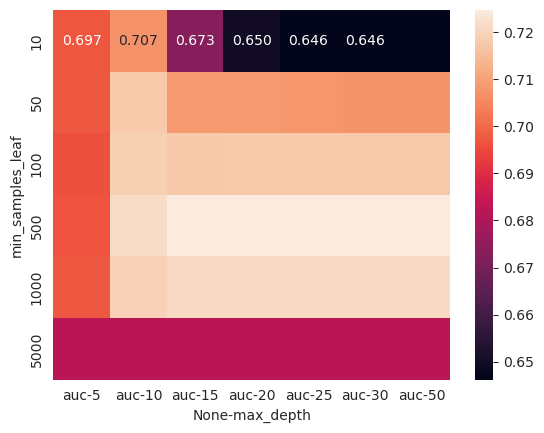

In [42]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

### Best Model 

* max_depth=15, 
* min_samples_leaf=500

In [43]:
print('...defining model with max_depth=15, min_samples_leaf=500')
dt_best = DecisionTreeClassifier(criterion='log_loss', 
                            max_depth=15, 
                            min_samples_leaf=500)

print('...fitting training data')
dt_best.fit(X_train, y_train)

# fitting to training set
print('...evaluation of fit')
y_fit = dt_best.predict_proba(X_train)[:, 1]
print('Accuracy:', accuracy_score(y_train, y_fit >= 0.5))
print('AUC ROC:', roc_auc_score(y_train, y_fit))

# validation set predictions
print('...prediction scores on validation set')
y_pred = dt_best.predict_proba(X_val)[:, 1]
print('Accuracy:', accuracy_score(y_val, y_pred >= 0.5))
print('AUC ROC:', roc_auc_score(y_val, y_pred))

...defining model with max_depth=15, min_samples_leaf=500
...fitting training data
...evaluation of fit
Accuracy: 0.7993666591268944
AUC ROC: 0.7242365975632572
...prediction scores on validation set
Accuracy: 0.7929521396905818
AUC ROC: 0.7245582721914817


## Ensembles and random forest

In [ ]:
print('...defining model')
rf = RandomForestClassifier()

print('...fitting training data')
rf.fit(X_train, y_train)

# fitting to training set
print('...evaluation of fit')
y_fit = rf.predict_proba(X_train)[:, 1]
print('Accuracy:', accuracy_score(y_train, y_fit >= 0.5))
print('AUC ROC:', roc_auc_score(y_train, y_fit))

# validation set predictions
print('...prediction scores on validation set')
y_pred = rf.predict_proba(X_val)[:, 1]
print('Accuracy:', accuracy_score(y_val, y_pred >= 0.5))
print('AUC ROC:', roc_auc_score(y_val, y_pred))

...defining model
...fitting training data


### Hyper-parameter tuning

* n_estimators
* max_depth
* min_samples_leaf

In [ ]:
scores = []

for n in range(50, 1001, 50):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

plt.plot(df_scores.n_estimators, df_scores.auc)

In [ ]:
n_estimators = 500

In [ ]:
scores = []

for s in [3, 5, 10, 50]:
    for d in [10, 20, 30, 50]:
        rf = RandomForestClassifier(n_estimators=n_estimators,
                                    max_depth=d,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, d, auc))

        
columns = ['min_samples_leaf', 'max_depth', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [ ]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

### Best Model

In [ ]:
print('...defining model')
rf_best = RandomForestClassifier(n_estimators=500,
                            max_depth=3,
                            min_samples_leaf=50,
                            random_state=1)

print('...fitting training data')
rf_best.fit(X_train, y_train)

# fitting to training set
print('...evaluation of fit')
y_fit = rf_best.predict_proba(X_train)[:, 1]
print('Accuracy:', accuracy_score(y_train, y_fit >= 0.5))
print('AUC ROC:', roc_auc_score(y_train, y_fit))

# validation set predictions
print('...prediction scores on validation set')
y_pred = rf_best.predict_proba(X_val)[:, 1]
print('Accuracy:', accuracy_score(y_val, y_pred >= 0.5))
print('AUC ROC:', roc_auc_score(y_val, y_pred))

### Feature importance

In [ ]:
importances = rf_best.feature_importances_

forest_importances = pd.Series(importances, index=features)

print('10 most important')
display(forest_importances.sort_values(ascending=False)[:10])

print('10 least important')
display(forest_importances.sort_values(ascending=False)[-10:])

In [ ]:
forest_importances[forest_importances > 0.005]

## Gradient boosting and XGBoost

In [ ]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [ ]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
df_score = parse_xgb_output(output)

In [ ]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

In [ ]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

### Hyper-parameter tuning

Tuning the following parameters:

* eta
* max_depth
* min_child_weight

In [ ]:
xgb_model = xgb.XGBClassifier()

In [ ]:
xgb_params = {
              'eta': [0.01, 0.1, 1, 10],
              'max_depth': [3, 6, 9, 12],
              'min_child_weight': [1,10, 30]
              }

In [ ]:
clf = GridSearchCV(xgb_model, xgb_params, scoring='roc_auc')

clf.fit(X_train, y_train)

In [ ]:
clf.best_score_, clf.best_params_

In [ ]:
print('...defining best model')
xgb_best = xgb.XGBClassifier(eta=0.1, 
                             max_depth=9,
                             min_child_weight=1)

print('...fitting training data')
xgb_best.fit(X_train, y_train)

# fitting to training set
print('...evaluation of fit')
y_fit = xgb_best.predict_proba(X_train)[:, 1]
print('Accuracy:', accuracy_score(y_train, y_fit >= 0.5))
print('AUC ROC:', roc_auc_score(y_train, y_fit))

# validation set predictions
print('...prediction scores on validation set')
y_pred = xgb_best.predict_proba(X_val)[:, 1]
print('Accuracy:', accuracy_score(y_val, y_pred >= 0.5))
print('AUC ROC:', roc_auc_score(y_val, y_pred))

## LightGBM
* https://github.com/Microsoft/LightGBM

In [ ]:
lgb_clf = lgb.LGBMClassifier()
lgb_clf.fit(X_train, y_train)

# fitting to training set
print('...evaluation of fit')
y_fit = lgb_clf.predict_proba(X_train)[:, 1]
print('Accuracy:', accuracy_score(y_train, y_fit >= 0.5))
print('AUC ROC:', roc_auc_score(y_train, y_fit))

# validation set predictions
print('...prediction scores on validation set')
y_pred = lgb_clf.predict_proba(X_val)[:, 1]
print('Accuracy:', accuracy_score(y_val, y_pred >= 0.5))
print('AUC ROC:', roc_auc_score(y_val, y_pred))

### Hyper-parameter tuning

In [ ]:
lgbm = lgb.LGBMClassifier()

lgbm_params = {
              'n_estimators': [10, 50, 100, 500],
              'max_depth': [3, 6, 9, 12],
              'learning_rate' : [0.01, 0.1, 1.0],
              'boosting_type' : ['gbdt', 'dart', 'goss']
              }

clf = GridSearchCV(lgb_clf, lgb_params, scoring='roc_auc')

clf.fit(X_train, y_train)

In [ ]:
clf.best_score_, clf.best_params_

### Best Model

In [ ]:
print('...defining best model')
lgbm_best = lgb.LGBMClassifier(boosting_type='dart',
                                learning_rate=0.1,
                                max_depth=12,
                                n_estimators=500)

print('...fitting training data')
lgbm_best.fit(X_train, y_train)

# fitting to training set
print('...evaluation of fit')
y_fit = lgbm_best.predict_proba(X_train)[:, 1]
print('Accuracy:', accuracy_score(y_train, y_fit >= 0.5))
print('AUC ROC:', roc_auc_score(y_train, y_fit))

# validation set predictions
print('...prediction scores on validation set')
y_pred = lgbm_best.predict_proba(X_val)[:, 1]
print('Accuracy:', accuracy_score(y_val, y_pred >= 0.5))
print('AUC ROC:', roc_auc_score(y_val, y_pred))

## Summary Table: Modelling

In [ ]:
print(f"|{'Model':<30} | Accuracy \t| ROC AUC \t|")
print(f"|{'-----':<30} | -------- \t| ------- \t|")

for model in [lr_best, dt_best, rf_best, xgb_best, lgbm_best]:

    model_name = f"{model}".split("(")[0]
    y_pred = model.predict_proba(X_val)[:, 1]

    print(f"|{model_name:<30} | {accuracy_score(y_val, y_pred >= 0.5):0.3f} \t| {roc_auc_score(y_val, y_pred):0.3f} \t|")

# Saving models

In [ ]:
for model in [lr_best, dt_best, rf_best, xgb_best, lgbm_best]:

    model_name = f"{model}".split("(")[0]

    with open(f'../models/{model_name}.bin', 'wb') as f_out: # 'wb' means write-binary
        pickle.dump((scaler, ohe, model), f_out)

# Final Model: LGBMClassifier

* Loading the data again
* Cleaning and Preparing the data
* Feature engineering
* Separating target variable
* Reduce to relevant features
* Scaling and encoding numerical and categorical variables
* Hyper-parameter tuning
* Training using best LGBMClassifier parameters
* Saving encoders and final model

In [ ]:
data_loc = '../data/KaggleV2-May-2016.csv'

df = pd.read_csv(data_loc, 
                 parse_dates=['ScheduledDay', 'AppointmentDay'],
                 dtype={
                            'Scholarship':'bool',
                            'Hipertension':'bool',
                            'Diabetes':'bool',
                            'Alcoholism':'bool',
                            'SMS_received':'bool'
                     }
              )

In [ ]:
def prepare_data(df, test=False):
    df.rename(columns={'Hipertension':'Hypertension'}, inplace=True)
    
    # Make the column names lower-case and uniform
    df.columns = df.columns.str.lower().str.replace('-', '_')

    # Make the string values of categorical columns lower-case and uniform
    categorical_columns = df.dtypes[df.dtypes == 'object'].index.tolist()
    for col in categorical_columns:
        df[col] = df[col].str.lower().str.replace(' ', '_')

    # Make the target variable boolean
    if test==False:
        df.no_show = (df.no_show == 'yes').astype(int)       

    return df

df = prepare_data(df)
#df.head()

In [ ]:
def feature_engineering(df):
    # Credit: https://github.com/fastai/fastai/blob/master/fastai/tabular/core.py#L26

    attr = ['Year', 'Month', 'Week', 'Day', 
            'Dayofweek', 'Dayofyear', 
            'Is_month_end', 'Is_month_start', 
            'Is_quarter_end', 'Is_quarter_start',  
            'Hour', 'Minute', 'Second']

    for field_name in ['scheduledday', 'appointmentday']:

        field = df[field_name]
        prefix = field_name
        
        week = field.dt.isocalendar().week.astype(field.dt.day.dtype) if hasattr(field.dt, 'isocalendar') else field.dt.week
        for n in attr: df[prefix + n] = getattr(field.dt, n.lower()) if n != 'Week' else week   

        df.drop(field_name, axis=1, inplace=True)

    return df

df = feature_engineering(df)
#df.head()


In [ ]:
y_train = df.no_show.values

del df['no_show']

In [ ]:
numerical = [
            'patientid',
            'age',
            'scheduleddayWeek',
            'scheduleddayDay',
            'scheduleddayDayofyear',
            'scheduleddayHour',
            'scheduleddayMinute',
            'scheduleddaySecond',
            'appointmentdayDay',
            'appointmentdayDayofyear'
            ]

categorical = [
                'gender',
                'scholarship',
                'hypertension',
                'diabetes',
                'alcoholism',
                'handcap',
                'sms_received',
                'scheduleddayYear',
                'scheduleddayMonth',
                'scheduleddayDayofweek',
                'scheduleddayIs_month_end',
                'scheduleddayIs_month_start',
                'scheduleddayIs_quarter_end',
                'scheduleddayIs_quarter_start',
                'appointmentdayMonth',
                'appointmentdayWeek',
                'appointmentdayDayofweek',
                'appointmentdayIs_month_end',
                'appointmentdayIs_month_start',
                'neighbourhood'
            ]

df = df[numerical + categorical]
#df.head()

In [ ]:
X_train_num = df[numerical]

scaler = StandardScaler()
#scaler = MinMaxScaler()

X_train_num = scaler.fit_transform(X_train_num)

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_train_cat = ohe.fit_transform(df[categorical])

X_train = np.column_stack([X_train_num, X_train_cat])
features = [feature for feature in np.append(scaler.get_feature_names_out(),ohe.get_feature_names_out())]

In [ ]:
lgbm_best = lgb.LGBMClassifier(boosting_type='dart',
                                learning_rate=0.1,
                                max_depth=12,
                                n_estimators=500)

lgbm_best.fit(X_train, y_train)

# fitting to training set
print('...evaluation of fit')
y_fit = lgbm_best.predict_proba(X_train)[:, 1]
print('Accuracy:', accuracy_score(y_train, y_fit >= 0.5))
print('AUC ROC:', roc_auc_score(y_train, y_fit))

In [ ]:
print('...saving model')
model_name = "LGBMClassifier_tranformers_final"

with open(f'../models/{model_name}.bin', 'wb') as f_out: # 'wb' means write-binary
    pickle.dump((scaler, ohe, lgbm_best), f_out)

# Loading model

In [ ]:
model_file = '../models/LGBMClassifier_tranformers_final.bin'

with open(model_file, 'rb') as f_in:
    (scaler, ohe, model) = pickle.load(f_in)

scaler, ohe, model

In [ ]:
! md5sum ../models/LGBMClassifier_tranformers_final.bin

# Predictions

## Sample appointment

In [ ]:
test_appointment = {
                    'PatientId': 377511518121127.0,
                    'AppointmentID': 5629448,
                    'Gender': 'F',
                    'ScheduledDay': pd.Timestamp('2016-04-27 13:30:56+0000', tz='UTC'),
                    'AppointmentDay': pd.Timestamp('2016-06-07 00:00:00+0000', tz='UTC'),
                    'Age': 54,
                    'Neighbourhood': 'MARIA ORTIZ',
                    'Scholarship': False,
                    'Hipertension': False,
                    'Diabetes': False,
                    'Alcoholism': False,
                    'Handcap': 0,
                    'SMS_received': True
                    }

## Prepare test sample

In [ ]:
def prepare_test(test_appointment):
    df_test = pd.DataFrame(test_appointment, index=[0])
    df_test = prepare_data(df_test, test=True)
    df_test = feature_engineering(df_test)

    X_test_num = scaler.transform(df_test[numerical])
    X_test_cat = ohe.transform(df_test[categorical])
    X_test = np.column_stack([X_test_num, X_test_cat])

    return X_test

X_test = prepare_test(test_appointment)

## Make prediction

In [ ]:
def predict(test_appointment):
    X_test = prepare_test(test_appointment)
    y_pred = model.predict_proba(X_test)[0,1]
    return y_pred

In [ ]:
predict(test_appointment)